## Word2Vec Model

Written by: Timothy (tq.wang93@hotmail.com)

Initial draft: November 2020

Last update: November 2020

<img style="float: center;" src="Figures/word2vec_head.png" width="100%"> 

---

### Introduction

Word2Vec was introduced by a team of researchers at Google in [2013](https://arxiv.org/abs/1301.3781), which is one of the most widely used neural network language models.

The underlying assumption of Word2Vec is that two words sharing **_similar contexts_** also share a **_similar meaning_** ([Distributional Hypothesis](https://aclweb.org/aclwiki/Distributional_Hypothesis)) and consequently a **_similar vector representation_** from the model. For instance, "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

#### How does Word2Vec learn the representation of a word?

The Word2Vec learns the representation of words from sentences. The word we focus on to learn its representation is called **_center word_**, and the words around it are called **_context words_**. The window size C determines the number of context words which is considered. 

Here, let’s see the algorithm by using an example sentence: **"The cute cat jumped over the lazy dog"**.

- All of the following figures consider “cat” as the center word.
- According to the window size C, we can see that the number of context words is changed.

<img style="float: center;" src="Figures/center_context_word.png" width="50%"> 

So, in order to learn the representation of a word, we will try to learn the context in which a particular word appears. Now the question is how can we do that?

#### Main algorithm
It does so in one of two ways, either using context to predict a target word (a method known as continuous bag of words, or **_CBOW_**), or using a word to predict a target context, which is called **_Skip-gram_**.

<img style="float: center;" src="Figures/CBOW_Skipgram.png" width="60%"> 

#### An intuitive understanding of Skip-gram

The ideas behind the two algorithms are quite similar, so I take Skip-gram to illustrate how it works. 

Skip-gram uses the current word **_w_** in order to predict its neighbors (i.e., its **_context_**). To limit the number of words in each context, let's set the parameter **_window size_** to 2. As the window slides against the training text, we create our training samples in our training dataset:

<img style="float: center;" src="Figures/generate_train_sample.png" width="60%"> 

We cannot feed the neural network with inputs of actual characters, so we have to find a way to represent these words. One way to do that is to create a **_vocabulary_** of all the words in our text corpus and then to encode our word as a vector of the same dimension of our vocabulary. Each dimension can be thought as a word in our vocabulary. So we will have a vector with all zeros and a 1 which represents the corresponding word in the vocabulary. This encoding technique is called **_one-hot encoding_**. Considering our example, suppose our text corpus contains only one sentence made of the words“the”, “cute”, “cat”, “jumped”,“over”, “lazy”, “dog”, we would have the following vector representation:

<img style="float: center;" src="Figures/one_hot_encoding.png" width="40%">

Here we have transformed the eight-word sentence into a 8×7 matrix, with the 7 being the size of the vocabulary (“the” is repeated). In the real practice, the size of vocabulary can be very large, which looks like what is shown below:

<img style="float: center;" src="Figures/one_hot_encoding_more_real.png" width="60%">

It should be noted that such a word representation is so scarse and tells nothing about the relation between word pairs (as the dot product of each pair of word vector is 0, which produces a cosine distance of 0). Yet, we can use these one-hot encodings to train our model. After that, we will get a more efficient representation of word semantics.

Now that we have our Skip-gram training dataset that we extracted from existing running text, let’s glance at how we use it to train a basic neural language model that predicts the context word. We start with a sample in our dataset - using the center word **_cat_** to predict the context word **_cute_**. The training includes the following operations:

<img style="float: center;" src="Figures/Skipgram_training.png" width="70%"> 

- First, multiply the one-hot encoding vector $x$ ($V×1$ dimension) and the word embedding matrix $W$ of size $V×N$ ($V$ is the size of the vocabulary and $N$ is the dimension of the word embedding; the elements in the matrix $W$ is initialized with random numbers) gives us the embedding vector of the input word $w_i$ (i.e., the word **_cat_** in our case).
- This newly discovered embedding vector of dimension $N$ forms the hidden layer.
- Multiply the hidden layer vector and the word context matrix $W'$ of size $N×V$ produces the predicted vector of the target word $\hat{y}$ (i.e., the word **_cute_** in our case).
- The predicted vector $\hat{y}$ is further compared to the actual target vector $y$ (of the word **_cute_** with one-hot encoding), and the error is used to update the word embedding matrix $W$ using backpropagation. The next time the model get **_cat_** as the input, it is more likely to guess **_cute_**.
- **Note:** the above process can be computationally intensive. To improve the performance, the technique of [negtive-sampling](http://jalammar.github.io/illustrated-word2vec/) is applied.

The above operations conclude the first step of the training. We proceed to do the same process with the next sample in our dataset, and then the next, until we have covered all the samples in the dataset. That concludes one **_epoch_** of training. We do it over again for a number of epochs, and then we have the so called Word2Vec model.

The by-product of the model - **_the embedding matrix_** - is extremely useful, as the weights are constantly adjusted during the whole process of training. Therefore, it can be used to represent the relations between words.  

We will soon show the magical word embeddings in our demo!


### Word2Vec Demo

#### Python implementation

For training and evaluating, we use [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html#documentation), a python package for language modeling which started with topic models (LDA) and grew into neural word representations (Word2Vec, GloVe).

#### Training the Word2Vec model
Here, we use the Word2Vec model downloaded from the [text-classification](https://github.com/wavewangyue/text-classification) project, which was trained on a large Chinese corpus (Baidu Baike). The current word2vec model contains 209969 word vectors with 200 dimensions.

#### Loading the model
The following code is used to load the model and store the word vectors in a dictionary.

In [ ]:
import gensim
from os.path import join

# directory path and model
dir_path = 'E:\\Projects\\Word_Semantics\\Word2Vec\\baike.vectors'
file_name = 'baike.vectors.bin'

# load model
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(join(dir_path, file_name), binary = True)
    
# get dictionary
vocab_dic = w2v_model.wv.vocab

# get vocabulary
vocab_ls = vocab_dic.keys()

# number of vocabularies in the dictionary
print('There are %s vocabularies in the dictionary.' % str(len(vocab_ls)))

#### Playing around with the pre-trained model

First, let's *obtain the vectors* for terms, as it is the most basic operation. 

It should be noted that:
- We can only obtain vectors for terms the model is familiar with (i.e., words in the dictionary). For unknown words, the model is unable to infer their vectors. 
- Alternatively, [FastText](https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html#sphx-glr-auto-examples-tutorials-run-fasttext-py) model can be used to obtain the vectors of unknown words.

For example, we would like to obtain the vector (200 dimensions) for the term "苹果".

In [ ]:
w2v_model['苹果']

Moving on, Word2Vec supports several word similarity tasks. Typically, the **_cosine similarity_** is used as the metric:

$$CosineSimilarity = \frac{U^TV}{\left\|U\right\|\left\|V\right\|}$$

<img style="float: center;" src="Figures/cosine_similarity.png" width="80%"> 

Let's see how the similarity intuitively decreases as the words get less and less similar.

In [40]:
import pandas as pd

pairs = [
    ('汽车', '货车'),     # a minivan is a kind of vehicle
    ('汽车', '自行车'),   # a bicycle is a wheeled vehicle
    ('汽车', '船'),       # a boat has no wheels, but still a vehicle
    ('汽车', '谷物'),     # cereal is a kind of food
    ('汽车', '共产主义')  # communism is a political belief
]

df_ls = []
for w1, w2 in pairs:
    df_ls += [[w1, w2, '%.3f' % w2v_model.similarity(w1, w2)]]
    
pd.DataFrame(df_ls, columns = ['Word 1', 'Word 2', 'Similarity'])

,Word 1,Word 2,Similarity
0,汽车,货车,0.526
1,汽车,自行车,0.533
2,汽车,船,0.157
3,汽车,谷物,0.102
4,汽车,共产主义,0.061


We can print the 5 most similar words to "香港大学".

In [41]:
top_similar = w2v_model.most_similar(['香港大学'], topn = 5)

# formatting
top_similar_ls = []
for i in range(len(top_similar)):
    top_similar_ls += [[top_similar[i][0], '%.3f' % top_similar[i][1]]]

pd.DataFrame(top_similar_ls, columns = ['Similar Word', 'Similarity'])

,Similar Word,Similarity
0,香港中文大学,0.912
1,美国哥伦比亚大学,0.825
2,新加坡国立大学,0.824
3,香港浸会大学,0.794
4,加拿大多伦多大学,0.792


The model can also detect words that do not belong to a certain semantic category. For example, we have a sequence of words {中国, 美国, 苹果, 英国, 日本}, and based on the model's prediction, "苹果" does not belong to the category of *country*.

In [ ]:
w2v_model.doesnt_match('中国 美国 苹果 英国 日本'.split())

The model can even do some analogical inference on relations (A is to B as C is to ?). The most well known example is the "*Man* is to *King* as *Woman* is to *Queen*" analogy, which can be represented as $King - Man + Woman = Queen$.

<img style="float: center;" src="Figures/king-man+woman.jpg" width="70%"> 
<img style="float: center;" src="Figures/analogy.png" width="80%"> 

Now, let's have a try using our model.

In [47]:
def analogy(x1, x2, y1):
    result = w2v_model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

print('国王 - 男人 + 女人 = %s' % analogy('男人', '女人', '国王'))
print('中国 - 北京 + 东京 = %s' % analogy('北京', '东京', '中国'))

国王 - 男人 + 女人 = 王后
中国 - 北京 + 东京 = 日本


Finally, we can visualize word vectors in the semantic space. To project the high-dimensional word embeddings to a 2D space, we can reduce dimensionality using PCA and t-SNE, which obtains lower-dimensional data while preserving as much of the data's variation as possible. Both methods are implemented in the machine learning package [sciket-learn](https://scikit-learn.org/stable/index.html).

<IPython.core.display.Javascript object>


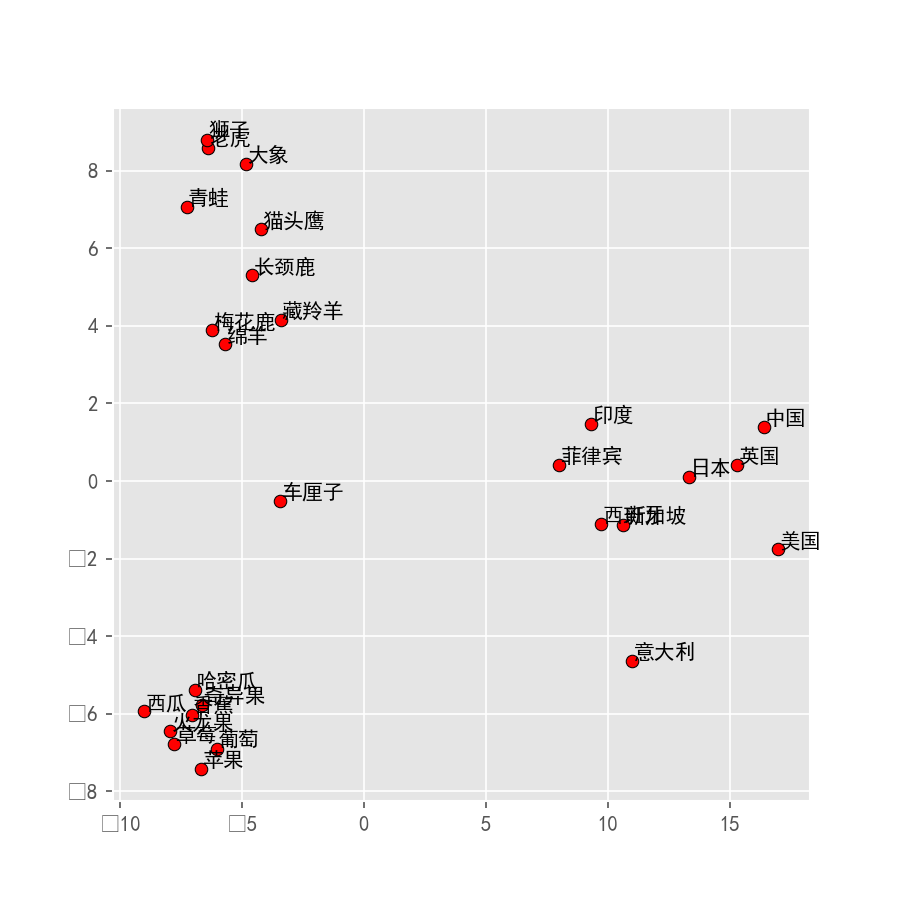

In [63]:
# scikit-learn: reduce dimensionality
import numpy as np
from sklearn.decomposition import PCA

# matplotlib: interactive plot
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

# show font in Chinese
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

# display PCA-based 2D scatterplot
def display_pca_scatterplot(model, words=None, sample=0):
    
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [word for word in model.vocab]
        
    word_vectors = np.array([model[w] for w in words])
    two_dim = PCA().fit_transform(word_vectors)[:, :2]
    
    plt.figure(figsize = (6, 6))
    plt.scatter(two_dim[:, 0], two_dim[:, 1], edgecolors = 'k', c = 'r')
    
    for word, (x,y) in zip(words, two_dim):
        plt.text(x + 0.05, y + 0.05, word)
        
        
# words to plot
word_plot = ['中国', '日本', '英国', '美国', '印度', '意大利', '西班牙', '新加坡', '菲律宾',
             '苹果', '香蕉', '西瓜', '草莓', '葡萄', '哈密瓜', '火龙果', '奇异果', '车厘子',
             '老虎', '狮子', '大象', '青蛙', '绵羊', '长颈鹿', '藏羚羊', '梅花鹿', '猫头鹰'] 

display_pca_scatterplot(w2v_model, word_plot)

### References
- [Stanford CS224n: Natural Language Processing with Deep Learning](http://web.stanford.edu/class/cs224n/)
- [The illustrated Word2Vec](http://jalammar.github.io/illustrated-word2vec/)
- [Demystifying Neural Network in Skip-Gram Language Modeling](https://aegis4048.github.io/demystifying_neural_network_in_skip_gram_language_modeling)
- [gensim documentation](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#evaluating)